In [1]:
from collections import Counter
from itertools import product
from nltk.tokenize.treebank import TreebankWordTokenizer
import numpy as np
import os
import pandas as pd
from datasets import load_dataset
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.utils.data
#from torch_model_base import TorchModelBase
#from torch_rnn_classifier import TorchRNNClassifier, TorchRNNModel
#from torch_shallow_neural_classifier import TorchShallowNeuralClassifier

import nli
import utils

In [2]:
utils.fix_random_seeds()

In [3]:
#Path for Glove Embeddings
GLOVE_HOME = os.path.join('data', 'glove.6B')

#DATA_HOME = os.path.join("data", "nlidata")

#ANNOTATIONS_HOME = os.path.join(DATA_HOME, "multinli_1.0_annotations")

In [4]:
#Loading the snli dataset 
snli = load_dataset("snli")

Reusing dataset snli (/Users/anisharitakula/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
#Initializing the Treebank tokenizer
tokenizer = TreebankWordTokenizer()

In [7]:
#Some utility functions I can create
#Reading in the dataframe
def df_reader(ds,split_type):
    all_data=ds[split_type]
    all_data_v1=[all_data[i] for i in range(len(all_data))]
    data_df=pd.DataFrame(all_data_v1)
    data_df=data_df[data_df['label']!=-1]
    return data_df

In [8]:
#Define matching words feature function
def matching_words(row):
    premise=row['premise']
    hypothesis=row['hypothesis']
    w1={w1.lower() for w1 in tokenizer.tokenize(premise)}
    w2={w2.lower() for w2 in tokenizer.tokenize(hypothesis)}
    a=Counter(w1&w2)
    return a

In [9]:
#All possible word combinations
def words_product(row):
    words1={w1.lower() for w1 in tokenizer.tokenize(row['premise'])}
    words2={w2.lower() for w2 in tokenizer.tokenize(row['hypothesis'])}
    return Counter(((w1,w2) for w1,w2 in product(words1,words2)))

In [29]:
#Glove average embeddings
def glove_embed_agg(row):
    a=[glove_lookup[w.lower()] for w in tokenizer.tokenize(row['premise']) if w.lower() in glove_lookup]
    b=[glove_lookup[w.lower()] for w in tokenizer.tokenize(row['hypothesis']) if w.lower() in glove_lookup]
    
    if len(a)==0:
        a=np.zeros(300)
    else:
        a=np.mean(a,axis=0)
    if len(b)==0:
        b=np.zeros(300)
    else:
        b=np.mean(b,axis=0)
    
    return np.concatenate((a,b))

In [10]:
#Creating vocabulary for the task depending on whether we are using Premise, Hypothesis or combination of two

def create_vocab(df,mincount,inclusion="p+h"):
    if inclusion=="p":
        words_counter=Counter([w.lower() for sent in df['premise'] for w in tokenizer.tokenize(sent)])
        words_list=[item[0] for item in words_counter.items() if item[1]>=mincount]
        words_list.append('$UNK')
        vocab=dict(zip(sorted(words_list),range(len(words_list))))
    elif inclusion=="h":
        words_counter=Counter([w.lower() for sent in df['hypothesis'] for w in tokenizer.tokenize(sent)])
        words_list=[item[0] for item in words_counter.items() if item[1]>=mincount]
        words_list.append('$UNK')
        vocab=dict(zip(sorted(words_list),range(len(words_list))))
    else:
        words_counter=Counter([w.lower() for sent in df['hypothesis'] for w in tokenizer.tokenize(sent)] + [w.lower() for sent in df['premise'] for w in tokenizer.tokenize(sent)])
        words_list=[item[0] for item in words_counter.items() if item[1]>=mincount]
        words_list.append('$UNK')
        vocab=dict(zip(sorted(words_list),range(len(words_list))))
    return vocab

In [11]:
#Extracting word indices
def words_indices1(row,inclusion="p+h"):
    
    if inclusion=="p":
        a=[vocab[w.lower()] if w.lower()in vocab.keys() else vocab['$UNK'] for w in tokenizer.tokenize(row['premise'])]
        return a
    elif inclusion=="h":
        b=[vocab[w.lower()] if w.lower()in vocab.keys() else vocab['$UNK'] for w in tokenizer.tokenize(row['hypothesis'])]
        return b
    else:
        a=[vocab[w.lower()] if w.lower()in vocab.keys() else vocab['$UNK'] for w in tokenizer.tokenize(row['premise'])]
        b=[vocab[w.lower()] if w.lower()in vocab.keys() else vocab['$UNK'] for w in tokenizer.tokenize(row['hypothesis'])]
        return a+b

In [45]:
#Function to build a dataset and load it for training in batches
def build_and_load_dataset(train_df,val_df,X_column,batch_size=32):
    #Creating train data
    X_train= torch.tensor(list(train_df[X_column]))
    y_train=torch.tensor(list(train_df['label']))

    #Creating validation data
    X_val= torch.tensor(list(val_df[X_column]))
    y_val=torch.tensor(list(val_df['label']))

    #Creating Dataset
    train_data=MyDataset(X_train,y_train)
    val_data=MyDataset(X_val,y_val)

    #Loading Dataset
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    
    return train_loader,val_loader

In [27]:
def model_run_softmax(train_df,val_df,embeds_column,max_iter=50):
    
    X=list(train_df[embeds_column])
    y=train_df['label']
    X_val=list(val_df[embeds_column])
    y_val=val_df['label']
    mod = LogisticRegression(
        fit_intercept=True,
        max_iter=max_iter,
        solver='liblinear',
        multi_class='ovr')
    mod.fit(X,y)
    y_pred_val=mod.predict(X_val)
    print(classification_report(y_val,y_pred_val,digits=3))

In [16]:
def model_run_softmax_Dictvectorizer(train_df,val_df,dv_column,max_iter=50):
    dv=DictVectorizer(sparse=True)
    X=dv.fit_transform(train_df[dv_column])
    y=train_df['label']
    X_val=dv.transform(val_df[dv_column])
    y_val=val_df['label']
    mod = LogisticRegression(
        fit_intercept=True,
        max_iter=max_iter,  ## A small number of iterations.
        solver='liblinear',
        multi_class='ovr')
    mod.fit(X,y)
    y_pred_val=mod.predict(X_val)
    print(classification_report(y_val,y_pred_val,digits=3))

In [71]:
#Function for training and evaluating the model
def train_evaluate_data(train_loader,val_loader,model,criterion,optimizer,num_epochs,patience,dtype=torch.long):
    #Training the data
    num_epochs = num_epochs

    # Define the early stopping criteria
    patience = patience
    delta = 0.01
    best_val_loss = float('inf')
    best_model = None
    counter = 0
    best_epoch=0

    for epoch in range(num_epochs):
        train_loss=0.0
        for i, (data, labels) in enumerate(train_loader):
            data = data.to(device,dtype=dtype)
            labels = labels.to(device)
            
            optimizer.zero_grad()#Setting all gradients to zero initially for each batch

            outputs = model(data)#Model predictions. There is where forward method is called
            
            loss = criterion(outputs, labels)#Loss calculation

            loss.backward()#Once the loss is calculated, backward pass starts
            optimizer.step()#The loss gradients from the backward pass passed to optimizer for updating parameters
        
            train_loss+=loss.item()
        
#         if (i+1) % 100 == 0:
#             print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
        print("Epoch {} is completed".format(epoch+1))
        print("Total train loss is {}".format(train_loss))
        #Evaluating model on validation data after each epoch  
        val_loss=0.0
        with torch.no_grad():#asking system to not update the gradients
            correct = 0
            total = 0
            actual=[]
            pred=[]
            for data, labels in val_loader:
                data = data.to(device,dtype=dtype)
                labels = labels.to(device,dtype=torch.long)

                outputs = model(data)#Predicting validation labels
                _, predicted = torch.max(outputs.data, 1)#If there are 3 output classes, this statement will find out what is the highest value and which class has it
            

                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
                actual+=list(labels)
                pred+=list(predicted)
            
                loss = criterion(outputs, labels)
                val_loss+=loss.item()

            accuracy = correct / total
            print(f'Validation accuracy: {accuracy:.4f}')
            print("Validation loss is {}".format(val_loss))
            print(classification_report(actual,pred,digits=3))
    
    
        if val_loss<best_val_loss-delta:
            best_val_loss=val_loss
            best_model = model.state_dict()
            best_epoch=epoch
            counter=0
        else:
            counter+=1
            if counter>=patience:
                print("Early stopping")
                break

    # Load the best model
    model.load_state_dict(best_model)
    print("Best epoch is {}".format(best_epoch))

In [113]:
def train_evaluate_data1(train_loader,val_loader,model,criterion,optimizer,num_epochs,patience):
    #Training the data
    num_epochs = num_epochs

    # Define the early stopping criteria
    patience = patience
    delta = 0.01
    best_val_loss = float('inf')
    best_model = None
    counter = 0
    best_epoch=0

    for epoch in range(num_epochs):
        train_loss=0.0
        for i, (data1,data2, labels) in enumerate(train_loader):
            data1 = data1.to(device)
            data2 = data2.to(device)
            labels = labels.to(device)
            
            #print(data1.shape,data2.shape,labels.shape)
            
            optimizer.zero_grad()#Setting all gradients to zero initially for each batch

            outputs = model(data1,data2)#Model predictions. There is where forward method is called
            
            loss = criterion(outputs, labels)#Loss calculation

            loss.backward()#Once the loss is calculated, backward pass starts
            optimizer.step()#The loss gradients from the backward pass passed to optimizer for updating parameters
        
            train_loss+=loss.item()
        
#         if (i+1) % 100 == 0:
#             print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
        print("Epoch {} is completed".format(epoch+1))
        print("Total train loss is {}".format(train_loss))
        #Evaluating model on validation data after each epoch  
        val_loss=0.0
        with torch.no_grad():#asking system to not update the gradients
            correct = 0
            total = 0
            actual=[]
            pred=[]
            for data1, data2, labels in val_loader:
                data1 = data1.to(device)
                data2 = data2.to(device)
                labels = labels.to(device)

                outputs = model(data1,data2)#Predicting validation labels
                _, predicted = torch.max(outputs.data, 1)#If there are 3 output classes, this statement will find out what is the highest value and which class has it
            

                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
                actual+=list(labels)
                pred+=list(predicted)
            
                loss = criterion(outputs, labels)
                val_loss+=loss.item()

            accuracy = correct / total
            print(f'Validation accuracy: {accuracy:.4f}')
            print("Validation loss is {}".format(val_loss))
            print(classification_report(actual,pred,digits=3))
    
    
        if val_loss<best_val_loss-delta:
            best_val_loss=val_loss
            best_model = model.state_dict()
            best_epoch=epoch
            counter=0
        else:
            counter+=1
            if counter>=patience:
                print("Early stopping")
                break

    # Load the best model
    model.load_state_dict(best_model)
    print("Best epoch is {}".format(best_epoch))

### Establishing some baselines MODEL 1: Matching words between premise and hypothesis

In [14]:
t_df=df_reader(snli,'train')
v_df=df_reader(snli,'validation')

In [18]:
t_df['counter']=t_df.apply(matching_words,axis=1)
v_df['counter']=v_df.apply(matching_words,axis=1)

In [19]:
model_run_softmax_Dictvectorizer(t_df,v_df,'counter')

              precision    recall  f1-score   support

           0      0.509     0.455     0.481      3329
           1      0.410     0.223     0.289      3235
           2      0.459     0.715     0.559      3278

    accuracy                          0.466      9842
   macro avg      0.459     0.465     0.443      9842
weighted avg      0.460     0.466     0.444      9842



### MODEL2: All words combination between premise and hypothesis

In [23]:
t_df['counter1']=t_df.apply(words_product,axis=1)
v_df['counter1']=v_df.apply(words_product,axis=1)

In [24]:
model_run_softmax_Dictvectorizer(t_df,v_df,'counter1')

              precision    recall  f1-score   support

           0      0.743     0.805     0.772      3329
           1      0.714     0.678     0.696      3235
           2      0.790     0.762     0.776      3278

    accuracy                          0.749      9842
   macro avg      0.749     0.748     0.748      9842
weighted avg      0.749     0.749     0.748      9842



/opt/anaconda3/envs/nlu/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### MODEL 3: Dense representations with softmax

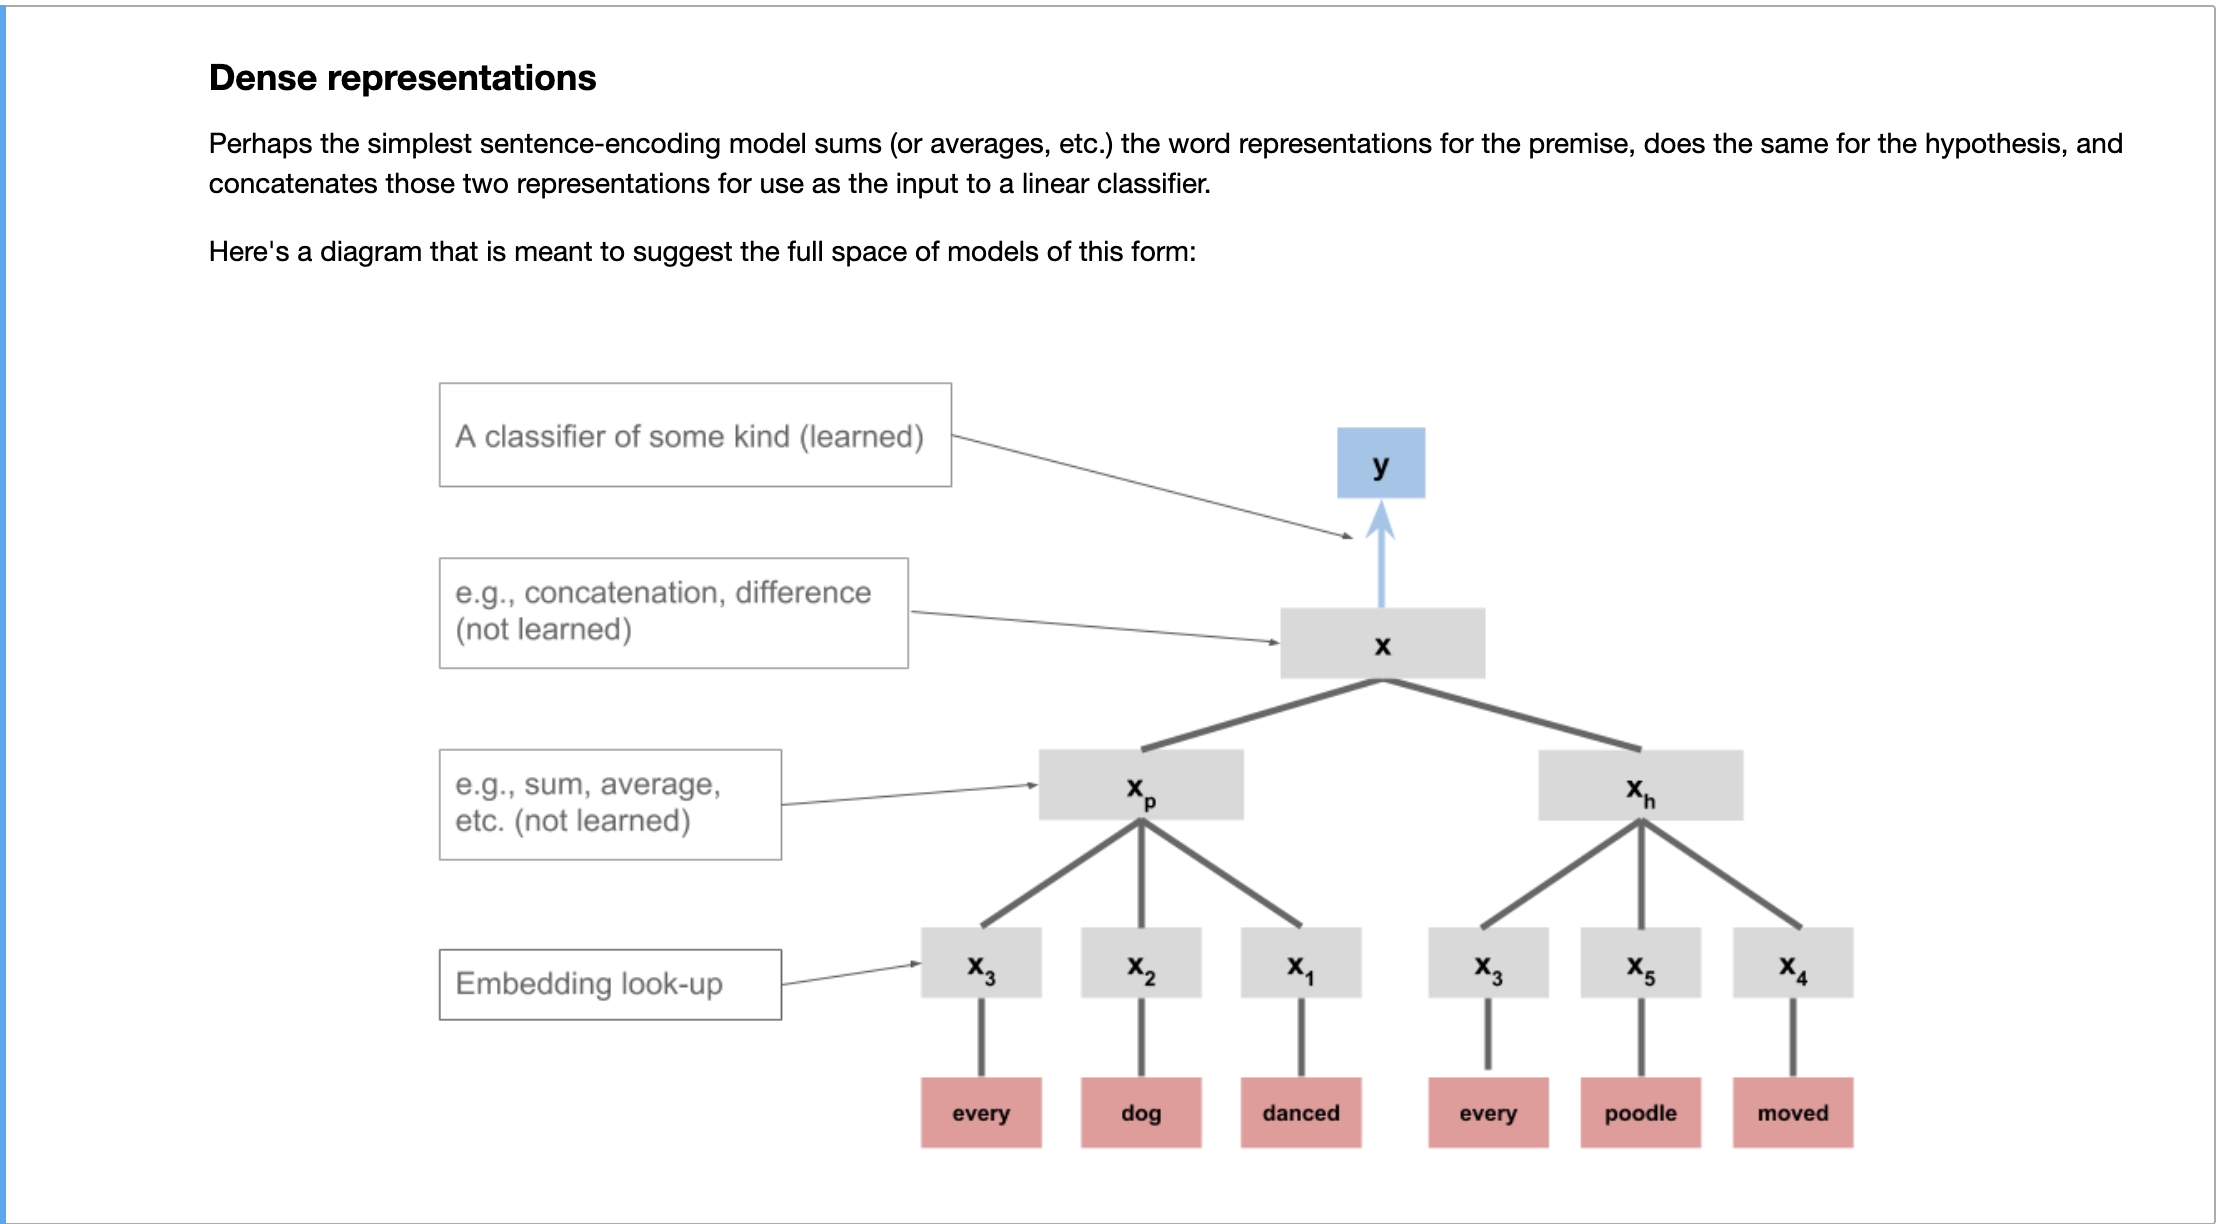

In [25]:
#The idea is to use word embeddings(Example Glove to extract 
#a) Sentence level embeddings for premise & Hypothesis(using sum or average etc)
#b) Concatenate the final embedding of both premise & hypothesis and pass it to the classifier layer

In [30]:
glove_lookup = utils.glove2dict(os.path.join(GLOVE_HOME, 'glove.6B.300d.txt'))
t_df['glove_embed']=t_df.apply(glove_embed_agg,axis=1)
v_df['glove_embed']=v_df.apply(glove_embed_agg,axis=1)

In [31]:
model_run_softmax(t_df,v_df,'glove_embed')

              precision    recall  f1-score   support

           0      0.591     0.624     0.607      3329
           1      0.602     0.584     0.592      3235
           2      0.579     0.563     0.571      3278

    accuracy                          0.590      9842
   macro avg      0.590     0.590     0.590      9842
weighted avg      0.590     0.590     0.590      9842



### MODEL4: Dense representations with Neural network

In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(600, 128)
        self.fc2 = nn.Linear(128, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        #x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model = MyModel().to(device)

In [67]:
train_loader,val_loader=build_and_load_dataset(t_df,v_df,'glove_embed')

/var/folders/84/skgmh_gx5bx_zpl3v_kjpwym0000gn/T/ipykernel_30907/4249976180.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data)  # Convert list of vectors to a PyTorch tensor
/var/folders/84/skgmh_gx5bx_zpl3v_kjpwym0000gn/T/ipykernel_30907/4249976180.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels)  # Convert list of labels to a PyTorch tensor


In [73]:
%%time
train_evaluate_data(train_loader,val_loader,model,nn.CrossEntropyLoss(),optim.Adam(model.parameters(), lr=0.001),50,5,torch.float32)

Epoch 1 is completed
Total train loss is 14410.341428756714
Validation accuracy: 0.6664
Validation loss is 236.02203410863876
              precision    recall  f1-score   support

           0      0.644     0.756     0.696      3329
           1      0.629     0.654     0.641      3235
           2      0.749     0.588     0.659      3278

    accuracy                          0.666      9842
   macro avg      0.674     0.666     0.665      9842
weighted avg      0.674     0.666     0.665      9842

Epoch 2 is completed
Total train loss is 12886.954473167658
Validation accuracy: 0.6857
Validation loss is 224.54863584041595
              precision    recall  f1-score   support

           0      0.692     0.725     0.708      3329
           1      0.633     0.681     0.656      3235
           2      0.741     0.651     0.693      3278

    accuracy                          0.686      9842
   macro avg      0.689     0.686     0.686      9842
weighted avg      0.689     0.686     0.6

              precision    recall  f1-score   support

           0      0.784     0.669     0.722      3329
           1      0.648     0.719     0.682      3235
           2      0.731     0.760     0.745      3278

    accuracy                          0.716      9842
   macro avg      0.721     0.716     0.716      9842
weighted avg      0.721     0.716     0.716      9842

Epoch 18 is completed
Total train loss is 10661.904190301895
Validation accuracy: 0.7216
Validation loss is 204.9484469294548
              precision    recall  f1-score   support

           0      0.733     0.758     0.745      3329
           1      0.689     0.666     0.678      3235
           2      0.740     0.739     0.740      3278

    accuracy                          0.722      9842
   macro avg      0.721     0.721     0.721      9842
weighted avg      0.721     0.722     0.721      9842

Epoch 19 is completed
Total train loss is 10621.493152529001
Validation accuracy: 0.7231
Validation loss is 203.

### MODEL 5: Sentence encoding RNNs(Fasttext initialization)

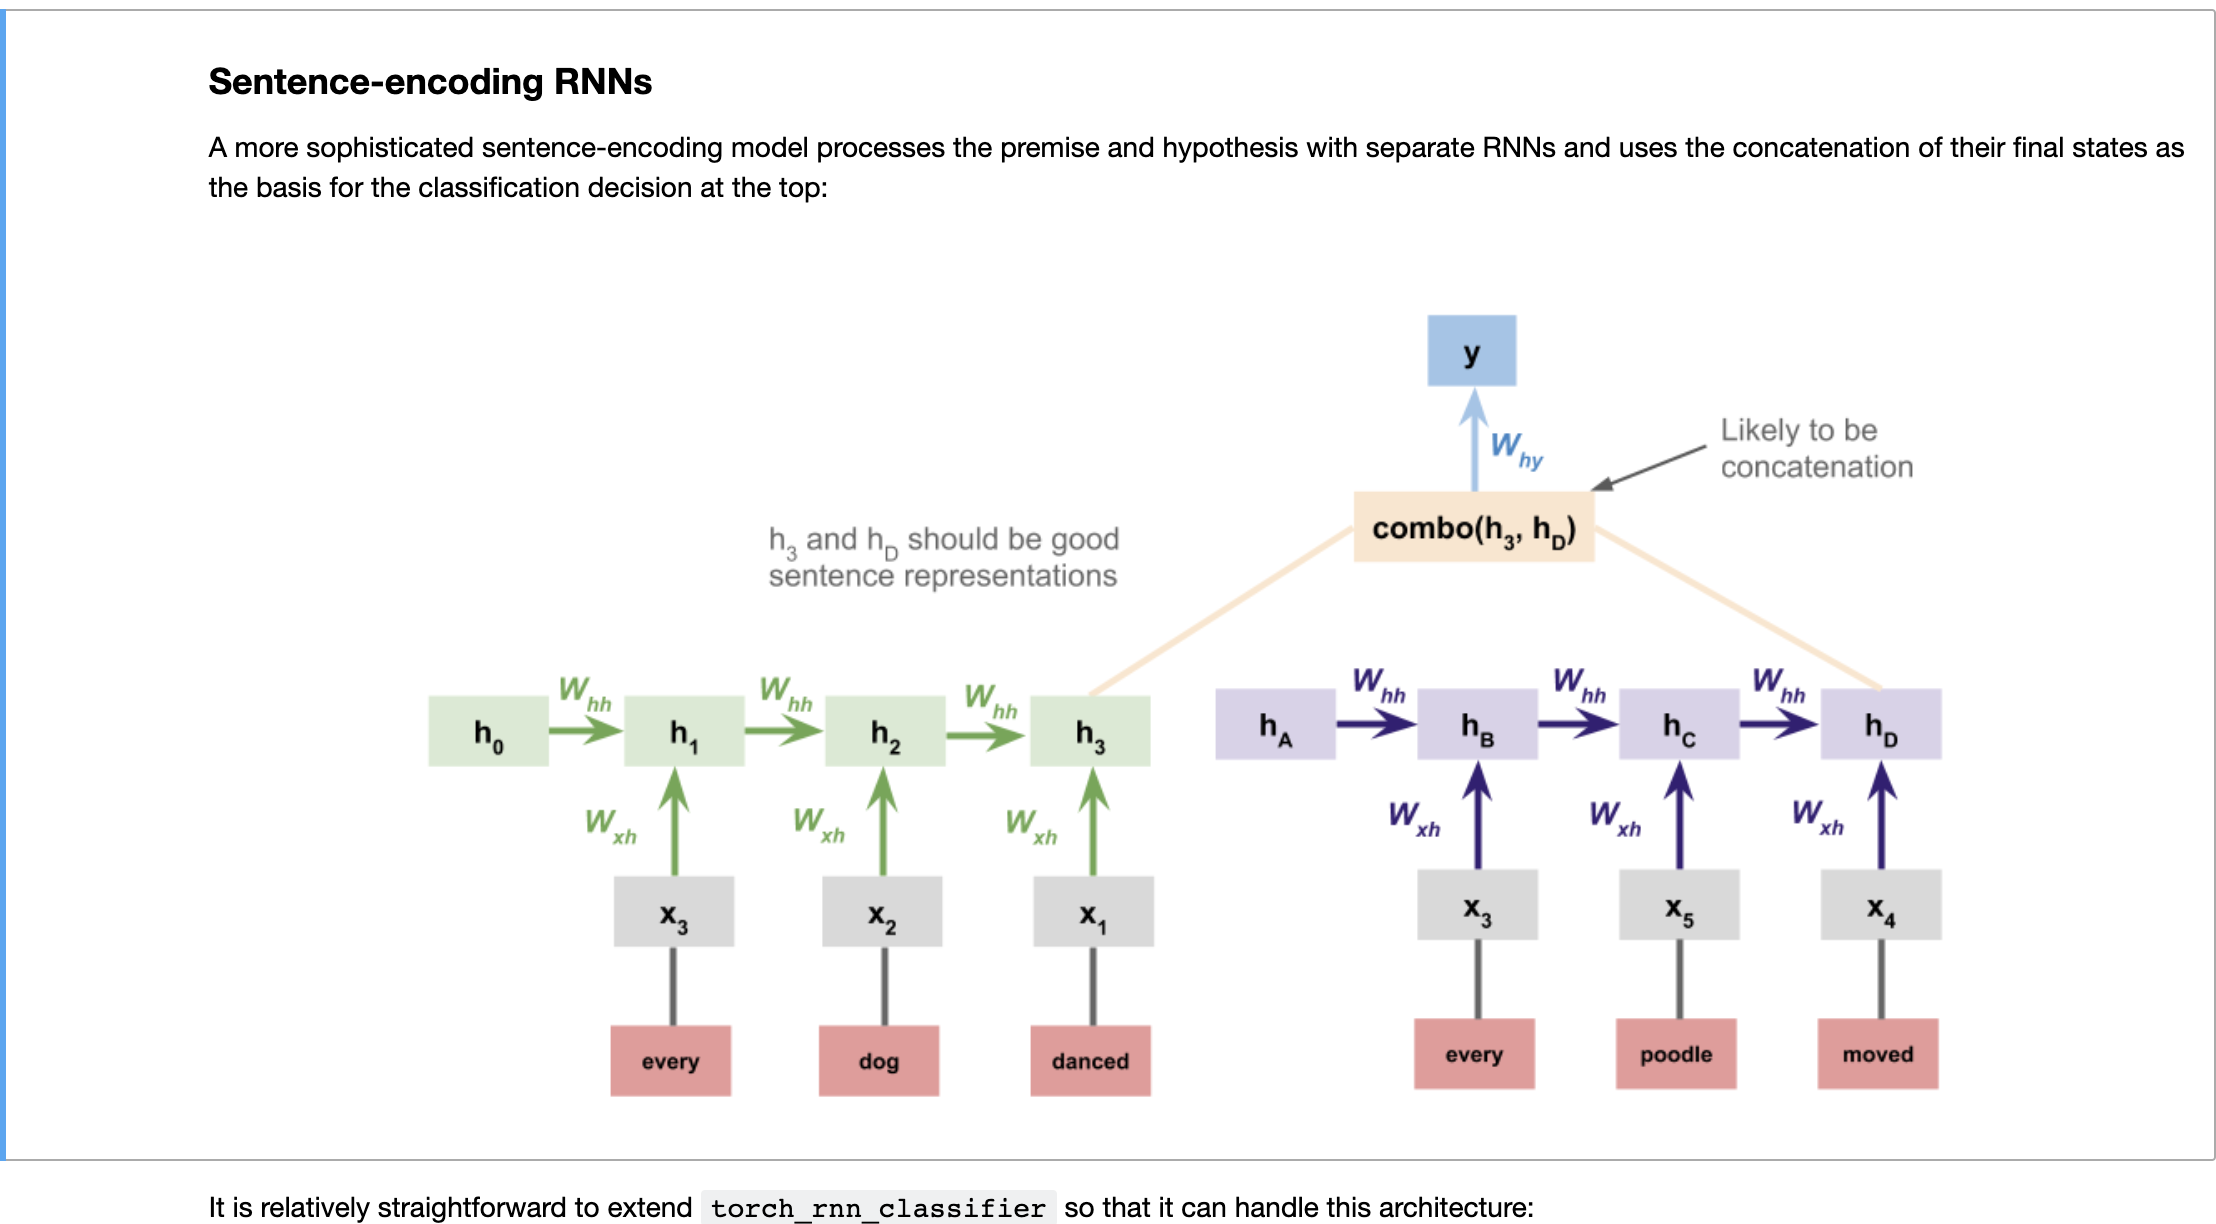

In [104]:
t_df['indices_p']=t_df.apply(lambda row:words_indices1(row,"p"),axis=1)
t_df['indices_h']=t_df.apply(lambda row:words_indices1(row,"h"),axis=1)

v_df['indices_p']=v_df.apply(lambda row:words_indices1(row,"p"),axis=1)
v_df['indices_h']=v_df.apply(lambda row:words_indices1(row,"h"),axis=1)

a=[len(indices) for indices in t_df['indices_p']]
pd.Series(a).describe([0.1,.25,.3,.4,.5,.6,.75,.9,.95,.99,.999,1.0])

count    548886.000000
mean         13.994881
std           5.850501
min           2.000000
10%           8.000000
25%          10.000000
30%          10.000000
40%          12.000000
50%          13.000000
60%          14.000000
75%          17.000000
90%          22.000000
95%          25.000000
99%          33.000000
99.9%        44.000000
100%         58.000000
max          58.000000
dtype: float64

In [105]:
b=[len(indices) for indices in t_df['indices_h']]
pd.Series(b).describe([0.1,.25,.3,.4,.5,.6,.75,.9,.95,.99,.999,1.0])

count    548886.000000
mean          8.242582
std           3.174929
min           1.000000
10%           5.000000
25%           6.000000
30%           6.000000
40%           7.000000
50%           8.000000
60%           8.000000
75%          10.000000
90%          12.000000
95%          14.000000
99%          19.000000
99.9%        25.000000
100%         40.000000
max          40.000000
dtype: float64

In [106]:
t_df['length_p']=t_df['indices_p'].apply(lambda x: len(x))
t_df['length_h']=t_df['indices_h'].apply(lambda x: len(x))

t_df=t_df[(t_df['length_p']<=47) & (t_df['length_h']<=26)]

In [107]:
#padding data for train and val and Truncating data for Validation where data>65 words
max_length_p=max(t_df['length_p'])
max_length_h=max(t_df['length_h'])

t_df['indices_p']=t_df['indices_p'].apply(lambda x: x + [0]*(max_length_p-len(x)))#padding to max length
t_df['indices_h']=t_df['indices_h'].apply(lambda x: x + [0]*(max_length_h-len(x)))#padding to max length

v_df['indices_p']=v_df['indices_p'].apply(lambda x: x + [0]*(max_length_p-len(x)) if len(x)<=max_length_p else x[0:max_length_p])#Truncation for Premise
v_df['indices_h']=v_df['indices_h'].apply(lambda x: x + [0]*(max_length_h-len(x)) if len(x)<=max_length_h else x[0:max_length_h])#Truncation for Hypothesis

print(max_length_p,max_length_h)

47 26


In [108]:
class MyDataset1(Dataset):
    def __init__(self, data1, data2, labels):
        self.data1 = torch.tensor(data1)  # Convert list of vectors to a PyTorch tensor premise
        self.data2 = torch.tensor(data2)  # Convert list of vectors to a PyTorch tensor hypothesis
        self.labels = torch.tensor(labels)  # Convert list of labels to a PyTorch tensor

    def __len__(self):
        return len(self.data1)

    def __getitem__(self, idx):
        return self.data1[idx], self.data2[idx], self.labels[idx]

#Creating train data
X_train_p= torch.tensor(list(t_df['indices_p']))
X_train_h= torch.tensor(list(t_df['indices_h']))
y_train2=torch.tensor(list(t_df['label']))

#Creating validation data
X_val_p= torch.tensor(list(v_df['indices_p']))
X_val_h= torch.tensor(list(v_df['indices_h']))
y_val2=torch.tensor(list(v_df['label']))

#Creating Dataset
train_data2=MyDataset1(X_train_p,X_train_h,y_train2)
val_data2=MyDataset1(X_val_p,X_val_h,y_val2)


#Loading Dataset
train_loader2 = torch.utils.data.DataLoader(train_data2, batch_size=64, shuffle=True)
val_loader2 = torch.utils.data.DataLoader(val_data2, batch_size=64)


/var/folders/84/skgmh_gx5bx_zpl3v_kjpwym0000gn/T/ipykernel_30907/2408318905.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data1 = torch.tensor(data1)  # Convert list of vectors to a PyTorch tensor premise
/var/folders/84/skgmh_gx5bx_zpl3v_kjpwym0000gn/T/ipykernel_30907/2408318905.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data2 = torch.tensor(data2)  # Convert list of vectors to a PyTorch tensor hypothesis
/var/folders/84/skgmh_gx5bx_zpl3v_kjpwym0000gn/T/ipykernel_30907/2408318905.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

In [111]:
class RNNClassifier_2_sep_RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        et = torch.tensor(embedding_matrix, dtype=torch.float32)
        self.embedding.weight = nn.Parameter(et)
        #self.embedding.weight.requires_grad = False
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim,batch_first=True,bidirectional=True)
        self.lstm2 = nn.LSTM(embedding_dim, hidden_dim,batch_first=True,bidirectional=True)
        
        self.hidden_layer=nn.Linear(hidden_dim*4, hidden_dim)
        self.classifier_activation = nn.ReLU()
        self.classifier_layer = nn.Linear(hidden_dim, output_dim)



    def forward(self, indices_p,indices_h):
        #print(indices_p.shape)
        embedded = self.embedding(indices_p)
        output,(hidden,cell_state)=self.lstm1(embedded)#capturing the final states of premise
        #print(hidden.shape,cell_state.shape)
        last2_hidden_states_bi1= torch.cat((hidden[-1,:,:],hidden[-2,:,:]),dim=1)
        
        embedded1=self.embedding(indices_h)
        output1,(hidden1,cell_state1)=self.lstm2(embedded1)
        #print(hidden1.shape)
        last2_hidden_states_bi2= torch.cat((hidden1[-1,:,:],hidden1[-2,:,:]),dim=1)
        #print(last2_hidden_states_bi.shape)
        
        combining_p_h_hidden_states=torch.cat((last2_hidden_states_bi1,last2_hidden_states_bi2),dim=1)
        
        
        x=self.hidden_layer(combining_p_h_hidden_states)
        h = self.classifier_activation(x)
        logits = self.classifier_layer(h)
        
        return logits

In [112]:
model3 = RNNClassifier_2_sep_RNN(len(vocab),300,150,3,embedding_matrix_fasttext).to(device)

In [114]:
%%time
train_evaluate_data1(train_loader2,val_loader2,model3,nn.CrossEntropyLoss(),optim.Adam(model3.parameters(), lr=0.001),50,5)

Epoch 1 is completed
Total train loss is 6237.131277024746
Validation accuracy: 0.7365
Validation loss is 97.82515987753868
              precision    recall  f1-score   support

           0      0.708     0.846     0.771      3329
           1      0.747     0.645     0.692      3235
           2      0.764     0.717     0.740      3278

    accuracy                          0.737      9842
   macro avg      0.740     0.736     0.734      9842
weighted avg      0.739     0.737     0.734      9842

Epoch 2 is completed
Total train loss is 4965.592612028122
Validation accuracy: 0.7626
Validation loss is 89.88064074516296
              precision    recall  f1-score   support

           0      0.728     0.870     0.793      3329
           1      0.753     0.702     0.727      3235
           2      0.821     0.713     0.763      3278

    accuracy                          0.763      9842
   macro avg      0.767     0.762     0.761      9842
weighted avg      0.767     0.763     0.761  

### MODEL6: Chained model RNNs(Randomized initialization)

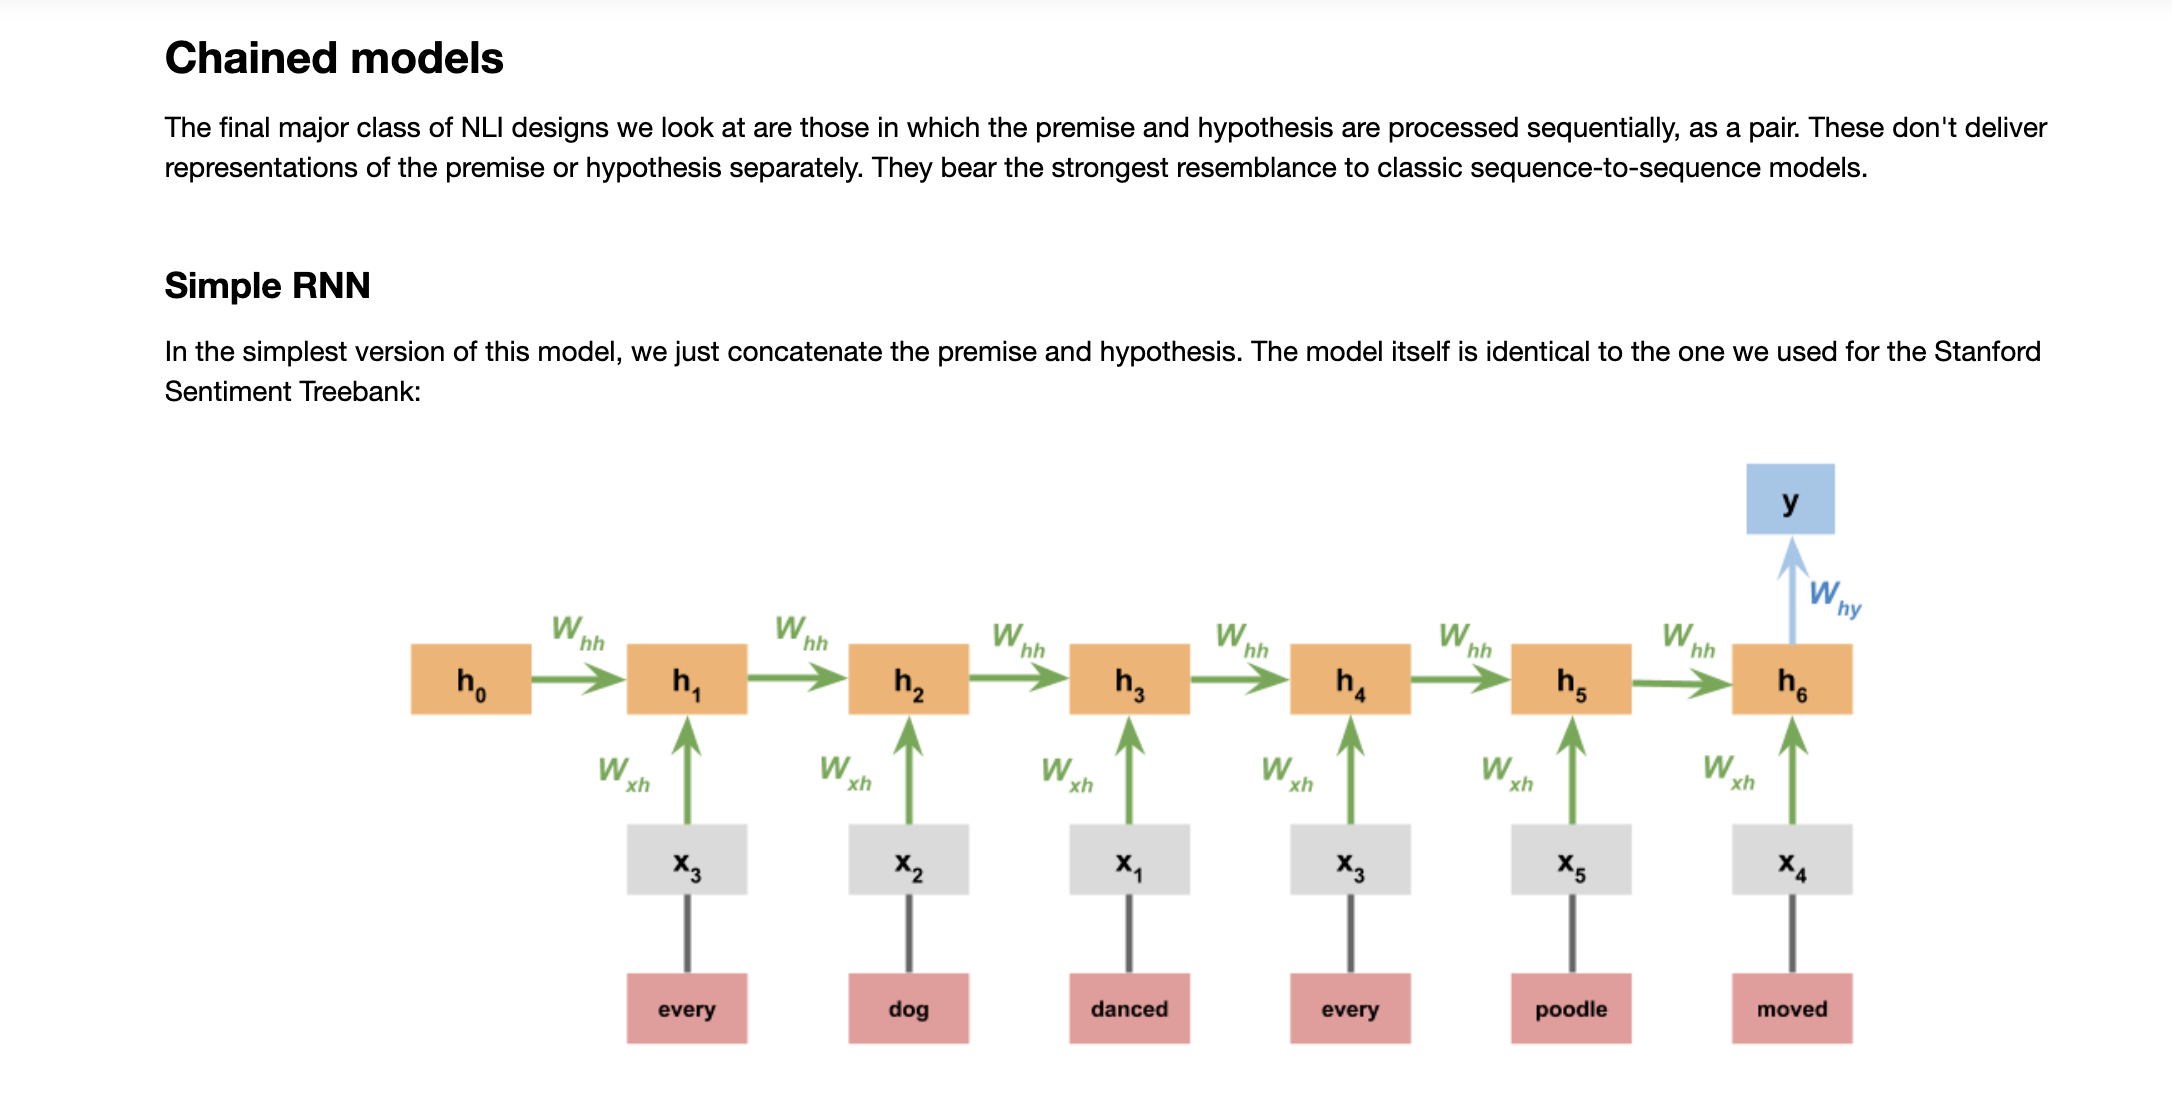

In [33]:
#Creating the vocabulary
vocab=create_vocab(t_df,1,"p+h")

In [38]:
#t_df['indices_ph']=t_df.apply(lambda row:words_indices1(row,"p+h"),axis=1)
#v_df['indices_ph']=v_df.apply(lambda row:words_indices1(row,"p+h"),axis=1)

a=[len(indices) for indices in t_df['indices_ph']]
b=pd.Series(a).describe([0.1,.25,.3,.4,.5,.6,.75,.9,.95,.99,.999,1.0])
b

count    549367.000000
mean         22.279797
std           7.300010
min           4.000000
10%          14.000000
25%          17.000000
30%          18.000000
40%          19.000000
50%          21.000000
60%          23.000000
75%          26.000000
90%          32.000000
95%          36.000000
99%          45.000000
99.9%        61.000000
100%        120.000000
max         120.000000
dtype: float64

In [41]:
t_df['length']=t_df['indices_ph'].apply(lambda x: len(x))
t_df=t_df[t_df['length']<=b['99.9%']]


In [42]:
#padding data for train and val and Truncating data for Validation where data>65 words
max_length=max(t_df['length'])
t_df['indices_ph']=t_df['indices_ph'].apply(lambda x: x + [0]*(max_length-len(x)))#padding to max length
v_df['indices_ph']=v_df['indices_ph'].apply(lambda x: x + [0]*(max_length-len(x)) if len(x)<=max_length else x[0:max_length])#Truncation for 
print(max_length,len(t_df),len(v_df))

61 548886 9842


/var/folders/84/skgmh_gx5bx_zpl3v_kjpwym0000gn/T/ipykernel_30907/1096048916.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['indices_ph']=t_df['indices_ph'].apply(lambda x: x + [0]*(max_length-len(x)))#padding to max length


In [43]:
#Class definition for Dataset format
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data)  # Convert list of vectors to a PyTorch tensor
        self.labels = torch.tensor(labels)  # Convert list of labels to a PyTorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [99]:
train_loader,val_loader=build_and_load_dataset(t_df,v_df,'indices_ph')

/var/folders/84/skgmh_gx5bx_zpl3v_kjpwym0000gn/T/ipykernel_30907/4249976180.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data)  # Convert list of vectors to a PyTorch tensor
/var/folders/84/skgmh_gx5bx_zpl3v_kjpwym0000gn/T/ipykernel_30907/4249976180.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels)  # Convert list of labels to a PyTorch tensor


In [54]:
# Define the RNN classifier model
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,batch_first=True,bidirectional=True)
        self.hidden_layer=nn.Linear(
            hidden_dim*2, hidden_dim)
        self.classifier_activation = nn.ReLU()
        self.classifier_layer = nn.Linear(
        hidden_dim, output_dim)


    def forward(self, indices):
        embedded = self.embedding(indices)
        #print(embedded.shape)
        output,hidden=self.lstm(embedded)
        last2_hidden_states_bi= torch.cat((hidden[0][-1,:,:],hidden[0][-2,:,:]),dim=1)
        #print(last2_hidden_states_bi.shape)
        x=self.hidden_layer(last2_hidden_states_bi)
        h = self.classifier_activation(x)
        logits = self.classifier_layer(h)
        
        return logits

In [55]:
model = RNNClassifier(len(vocab),300,300,3).to(device)

In [56]:
%%time
train_evaluate_data(train_loader,val_loader,model,nn.CrossEntropyLoss(),optim.Adam(model.parameters(), lr=0.001),50,5)

Epoch 1 is completed
Total train loss is 13861.923757821321
Validation accuracy: 0.6980
Validation loss is 219.5191471874714
              precision    recall  f1-score   support

           0      0.722     0.737     0.729      3329
           1      0.675     0.665     0.670      3235
           2      0.696     0.691     0.693      3278

    accuracy                          0.698      9842
   macro avg      0.698     0.698     0.698      9842
weighted avg      0.698     0.698     0.698      9842

Epoch 2 is completed
Total train loss is 11691.397907972336
Validation accuracy: 0.7200
Validation loss is 206.79994362592697
              precision    recall  f1-score   support

           0      0.739     0.768     0.753      3329
           1      0.704     0.662     0.683      3235
           2      0.715     0.728     0.721      3278

    accuracy                          0.720      9842
   macro avg      0.719     0.719     0.719      9842
weighted avg      0.719     0.720     0.71

### MODEL 7: Chained Model RNNs(Fasttext Embeddings Initialization)

In [94]:
#Setting up the glove embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, i in vocab.items():
    if word in glove_lookup.keys():
        embedding_matrix[i] = glove_lookup[word]

In [87]:
#!pip install fasttext
import fasttext.util
    
#Downloading and leveraging the fasttext english model containing word embeddings
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 (55.16%) [===========================>                       ]===========================>                       ]===========================>                       ]===========================>                       ]===========================>                       ]===========================>                       ]===========================>                       ]===========================>                       ]===========================>                       ]===========================>                       ]===========================>                       ]===========================>                       ]===========================>                       ]===========================>                       ]===========================>                       ]===========================>                       ]===========================>                       ]===========================>                       ]===========================>                       ]=

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 (93.83%) [==============================================>    ]==============================================>    ]==============================================>    ]==============================================>    ]==============================================>    ]==============================================>    ]==============================================>    ]==============================================>    ]==============================================>    ]==============================================>    ]==============================================>    ]==============================================>    ]==============================================>    ]==============================================>    ]==============================================>    ]==============================================>    ]==============================================>    ]==============================================>    ]==============================================>    ]=

 (100.00%) [==================================================>]================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=

In [95]:
ft.get_word_vector(word)
embedding_dim = 300
embedding_matrix_fasttext = np.zeros((len(vocab), embedding_dim))
for word, i in vocab.items():
    try:
        embedding_matrix_fasttext[i] = ft.get_word_vector(word)
    except KeyError:
        try:
            embedding_matrix_fasttext[i] = ft.get_word_vector(word.replace('-', ''))
        except KeyError:
            embedding_matrix_fasttext[i] = ft.get_word_vector(word.title())


In [100]:
class RNNClassifier_pretrained(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        et = torch.tensor(embedding_matrix, dtype=torch.float32)
        self.embedding.weight = nn.Parameter(et)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,batch_first=True,bidirectional=True)
        self.hidden_layer=nn.Linear(
            hidden_dim*2, hidden_dim)
        self.classifier_activation = nn.ReLU()
        self.classifier_layer = nn.Linear(
        hidden_dim, output_dim)


    def forward(self, indices):
        embedded = self.embedding(indices)
        #print(embedded.shape)
        output,hidden=self.lstm(embedded)
        last2_hidden_states_bi= torch.cat((hidden[0][-1,:,:],hidden[0][-2,:,:]),dim=1)
        #print(last2_hidden_states_bi.shape)
        x=self.hidden_layer(last2_hidden_states_bi)
        h = self.classifier_activation(x)
        logits = self.classifier_layer(h)
        
        return logits

In [101]:
model2 = RNNClassifier_pretrained(len(vocab),300,300,3,embedding_matrix_fasttext).to(device)

In [102]:
%%time
train_evaluate_data(train_loader,val_loader,model2,nn.CrossEntropyLoss(),optim.Adam(model2.parameters(), lr=0.001),50,5)

Epoch 1 is completed
Total train loss is 17008.94190889597
Validation accuracy: 0.6767
Validation loss is 230.37738931179047
              precision    recall  f1-score   support

           0      0.677     0.744     0.709      3329
           1      0.681     0.636     0.657      3235
           2      0.673     0.649     0.660      3278

    accuracy                          0.677      9842
   macro avg      0.677     0.676     0.676      9842
weighted avg      0.677     0.677     0.676      9842

Epoch 2 is completed
Total train loss is 11829.957348391414
Validation accuracy: 0.7295
Validation loss is 199.13170689344406
              precision    recall  f1-score   support

           0      0.744     0.761     0.753      3329
           1      0.694     0.707     0.700      3235
           2      0.751     0.719     0.735      3278

    accuracy                          0.730      9842
   macro avg      0.730     0.729     0.729      9842
weighted avg      0.730     0.730     0.73